# Projeto de Previsão de Rotatividade de Funcionários (Attrition)

Este notebook organiza scripts, análises e resultados do projeto de Machine Learning para prever a saída de funcionários.

## 1. Importar Bibliotecas e Configurações 

Nesta seção, vamos importar as principais bibliotecas para análise e modelagem de dados em Python.

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

In [166]:
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

## 2. Carregamento e Análise Inicial dos Dados

In [167]:
df = pd.read_csv("../data/raw/rh_data.csv")
print("Formato da base:", df.shape)
df.head()

Formato da base: (4410, 24)


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,4,Sales Executive,Married,193280,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,3,Human Resources,Married,83210,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,1,Sales Executive,Single,23420,4.0,Y,12,8,2,9.0,2,6,0,4


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

### 2.1. Tratamento Valores Nulos e Constantes

In [169]:
# Ver quantidade de valores nulos por coluna
print(df.isnull().sum())

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64


In [170]:
# Imputação de nulos
df['NumCompaniesWorked'] = df['NumCompaniesWorked'].fillna(1)
df.loc[df['NumCompaniesWorked'] == 0, 'NumCompaniesWorked'] = 1

# Imputação de TotalWorkingYears
df["TotalWorkingYears"] = np.where(
    df["TotalWorkingYears"].isnull(), 
    df["YearsAtCompany"], 
    df["TotalWorkingYears"]
)

print("Valores nulos após tratamento:")
print(df.isnull().sum().sum())

Valores nulos após tratamento:
0


In [171]:
# Remoção de colunas constantes e identificadores
cols_to_drop = ['StandardHours', 'Over18']
df.drop(columns=cols_to_drop, inplace=True)

In [172]:
# Remoção de duplicados (se houver)
df.drop_duplicates(keep='first', inplace=True)

## 3. Criar novas variáveis - Feature Engineering

In [173]:
# Faixa Etária
df["AgeGroup"] = pd.cut(df["Age"], bins=[18, 30, 40, 50, 60], 
                        labels=["18-30", "31-40", "41-50", "51-60"], right=False)

# Proporção de tempo de carreira na empresa atual
df['CompanyExperienceRatio'] = df['YearsAtCompany'] / (df['TotalWorkingYears'] + 1)

# Tempo médio por empresa
df['AvgYearsPerCompany'] = df['TotalWorkingYears'] / df['NumCompaniesWorked']

# Taxa de promoção
df['PromotionRate'] = df['YearsSinceLastPromotion'] / (df['TotalWorkingYears'] + 1)

# Distância de casa (binário: 0=perto, 1=longe)
df['FarFromHome'] = (df['DistanceFromHome'] > df['DistanceFromHome'].median()).astype(int)

# Experiência em múltiplas empresas: binária (se já trabalhou em mais de 3 empresas)
df["MultiCompanyExp"] = (df["NumCompaniesWorked"] > 3).astype(int)

# Gap desde última promoção: indicador se ficou >5 anos sem promoção.
df["LongTimeNoPromotion"] = (df["YearsSinceLastPromotion"] > 5).astype(int)

# Categoria de renda: agrupar MonthlyIncome em faixas
df["IncomeGroup"] = pd.qcut(df["MonthlyIncome"], q=4, labels=["Baixo", "Médio", "Alto", "Muito Alto"])

## 4. Pré-processamento para Modelagem

### 4.1. Codificação de Variáveis Categóricas

In [174]:
# Variável Target (Attrition) - Transformação para 0 e 1
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Separar features (X) e target (y)
y = df['Attrition']
X = df.drop(columns=['Attrition'])

# Identificar colunas para One-Hot Encoding (Nominais)
nominal_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'AgeGroup', 'IncomeGroup']

# Aplicar One-Hot Encoding
X = pd.get_dummies(X, columns=nominal_cols, drop_first=True)

# O LabelEncoder original foi removido, pois o One-Hot Encoding é mais apropriado para a maioria das categóricas aqui.

### 4.2. Divisão em Treino e Teste e Padronização (Scaling)

In [175]:
# Divisão em treino e teste (mantendo a estratificação)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        
    random_state=42,      
    stratify=y            
)

# Padronização (Scaling) - Essencial para modelos baseados em distância (Regressão Logística)
scaler = StandardScaler()

# Aplicar o fit SÓ no treino e transformar treino e teste
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converter de volta para DataFrame para manter a estrutura e nomes das colunas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

### 4.3. Tratamento de Desbalanceamento com SMOTE

In [176]:
if SMOTE:
    print("Proporção original da classe Attrition (Yes=1) no treino:", y_train.mean())
    
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
    
    print("\nProporção após SMOTE:", y_train_smote.mean())
    print("Tamanho do treino após SMOTE:", X_train_smote.shape)
else:
    # Se SMOTE não estiver disponível, usamos o conjunto original escalado
    X_train_smote, y_train_smote = X_train_scaled, y_train
    print("SMOTE não aplicado. Usando dados originais escalados.")

Proporção original da classe Attrition (Yes=1) no treino: 0.161281179138322

Proporção após SMOTE: 0.5
Tamanho do treino após SMOTE: (5918, 47)


## 5. Fazer uma análise exploratória - EDA

### 5.1. Agrupar e visualizar dados de acordo com variáveis categóricas

In [177]:
df.select_dtypes(include='object').columns

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus'],
      dtype='object')

In [178]:
df.select_dtypes(include='category').columns

Index(['AgeGroup', 'IncomeGroup'], dtype='object')

In [179]:
# Comparar médias das variáveis numéricas entre quem saiu (1) e ficou (0)

df.groupby('Attrition').mean(numeric_only=True)

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,CompanyExperienceRatio,AvgYearsPerCompany,PromotionRate,FarFromHome,MultiCompanyExp,LongTimeNoPromotion
Attrition,,,,,,,,,,,,,,,,,,,,,
0,37.561233,9.227088,2.919708,1.0,2208.139497,2.068938,65672.595296,2.781563,15.157340,0.796431,11.859151,2.827251,7.369019,2.234388,4.367397,0.593643,6.520056,0.173571,0.472019,0.293593,0.145985
1,33.607595,9.012658,2.877637,1.0,2191.767932,2.037975,61682.616034,3.022504,15.481013,0.780591,8.240506,2.654008,5.130802,1.945148,2.852321,0.522314,4.212375,0.186326,0.476793,0.350211,0.147679


In [180]:
# Diferença de médias entre os grupos

mean_diff = df.groupby('Attrition').mean(numeric_only=True).diff().iloc[-1].sort_values(ascending=False)
print(mean_diff)

PercentSalaryHike             0.323673
NumCompaniesWorked            0.240941
MultiCompanyExp               0.056618
PromotionRate                 0.012754
FarFromHome                   0.004774
LongTimeNoPromotion           0.001694
EmployeeCount                 0.000000
StockOptionLevel             -0.015841
JobLevel                     -0.030963
Education                    -0.042071
CompanyExperienceRatio       -0.071329
TrainingTimesLastYear        -0.173242
DistanceFromHome             -0.214430
YearsSinceLastPromotion      -0.289240
YearsWithCurrManager         -1.515076
YearsAtCompany               -2.238217
AvgYearsPerCompany           -2.307681
TotalWorkingYears            -3.618645
Age                          -3.953638
EmployeeID                  -16.371565
MonthlyIncome             -3989.979262
Name: 1, dtype: float64


#### 5.1.1. Departament

In [181]:
attrition_by_dept = df.groupby('Department')['Attrition'].mean().sort_values(ascending=False)
print(attrition_by_dept)

Department
Human Resources           0.301587
Research & Development    0.157128
Sales                     0.150224
Name: Attrition, dtype: float64


In [182]:
pd.crosstab(df['Department'], df['Attrition'], normalize='index') * 100

Attrition,0,1
Department,,
Human Resources,69.841270,30.158730
Research & Development,84.287201,15.712799
Sales,84.977578,15.022422


Insight: Pode haver problemas de retenção específicos no RH, como falta de oportunidades, sobrecarga ou desalinhamento entre expectativas e práticas organizacionais.

#### 5.1.2. Marital Status

In [183]:
attrition_by_marital = df.groupby('MaritalStatus')['Attrition'].mean().sort_values(ascending=False)
print(attrition_by_marital)

MaritalStatus
Single      0.255319
Married     0.124814
Divorced    0.100917
Name: Attrition, dtype: float64


In [184]:
pd.crosstab(df['MaritalStatus'], df['Attrition'], normalize='index') * 100

Attrition,0,1
MaritalStatus,,
Divorced,89.908257,10.091743
Married,87.518574,12.481426
Single,74.468085,25.531915


Insight: O estado civil está associado à estabilidadem, ou seja, funcionários com vínculos familiares tendem a permanecer mais tempo.

#### 5.1.3. Age Group

In [185]:
attrition_by_age = df.groupby('AgeGroup')['Attrition'].mean().sort_values(ascending=False)
print(attrition_by_age)

AgeGroup
18-30    0.279141
31-40    0.143087
51-60    0.136905
41-50    0.097421
Name: Attrition, dtype: float64


C:\Users\Notebook\AppData\Local\Temp\ipykernel_10764\3131432480.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attrition_by_age = df.groupby('AgeGroup')['Attrition'].mean().sort_values(ascending=False)


In [186]:
pd.crosstab(df['AgeGroup'], df['Attrition'], normalize='index') * 100

Attrition,0,1
AgeGroup,,
18-30,72.085890,27.914110
31-40,85.691318,14.308682
41-50,90.257880,9.742120
51-60,86.309524,13.690476


Insight: A retenção de jovens talentos é um ponto crítico, e políticas de engajamento ou desenvolvimento de carreira podem reduzir a saída precoce.

#### 5.1.4. Job Role

In [187]:
attrition_job_role = df.groupby('JobRole')['Attrition'].mean().sort_values(ascending=False)
print(attrition_job_role)

JobRole
Research Director            0.237500
Research Scientist           0.181507
Sales Executive              0.168712
Laboratory Technician        0.162162
Healthcare Representative    0.145038
Sales Representative         0.144578
Manager                      0.137255
Human Resources              0.134615
Manufacturing Director       0.110345
Name: Attrition, dtype: float64


In [188]:
pd.crosstab(df['JobRole'], df['Attrition'], normalize='index') * 100

Attrition,0,1
JobRole,,
Healthcare Representative,85.496183,14.503817
Human Resources,86.538462,13.461538
Laboratory Technician,83.783784,16.216216
Manager,86.274510,13.725490
Manufacturing Director,88.965517,11.034483
Research Director,76.250000,23.750000
Research Scientist,81.849315,18.150685
Sales Executive,83.128834,16.871166
Sales Representative,85.542169,14.457831


Os cargos técnicos de pesquisa merecem atenção especial, podem estar enfrentando fatores de desgaste ou poucas perspectivas de crescimento.

#### 5.1.5. Business Travel

In [189]:
attrition_business_trave = df.groupby('BusinessTravel')['Attrition'].mean().sort_values(ascending=False)
print(attrition_business_trave)

BusinessTravel
Travel_Frequently    0.249097
Travel_Rarely        0.149569
Non-Travel           0.080000
Name: Attrition, dtype: float64


In [190]:
pd.crosstab(df['BusinessTravel'], df['Attrition'], normalize='index') * 100

Attrition,0,1
BusinessTravel,,
Non-Travel,92.000000,8.000000
Travel_Frequently,75.090253,24.909747
Travel_Rarely,85.043145,14.956855


Insight: O volume de viagens parece ser um fator importante de rotatividade, especialmente entre perfis que viajam muito.

#### 5.1.6. In Come Group

In [191]:
attrition_in_come = df.groupby('IncomeGroup')['Attrition'].mean().sort_values(ascending=False)
print(attrition_in_come)

IncomeGroup
Alto          0.187500
Baixo         0.181572
Médio         0.142077
Muito Alto    0.133515
Name: Attrition, dtype: float64


C:\Users\Notebook\AppData\Local\Temp\ipykernel_10764\2920599376.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attrition_in_come = df.groupby('IncomeGroup')['Attrition'].mean().sort_values(ascending=False)


In [192]:
pd.crosstab(df['IncomeGroup'], df['Attrition'], normalize='index') * 100

Attrition,0,1
IncomeGroup,,
Baixo,81.842818,18.157182
Médio,85.792350,14.207650
Alto,81.250000,18.750000
Muito Alto,86.648501,13.351499


Insight: A remuneração não atua isoladamente, pode ser observado que o contexto de carreira e motivação pessoal também influencia a permanência.

#### 5.1.7. Visualização

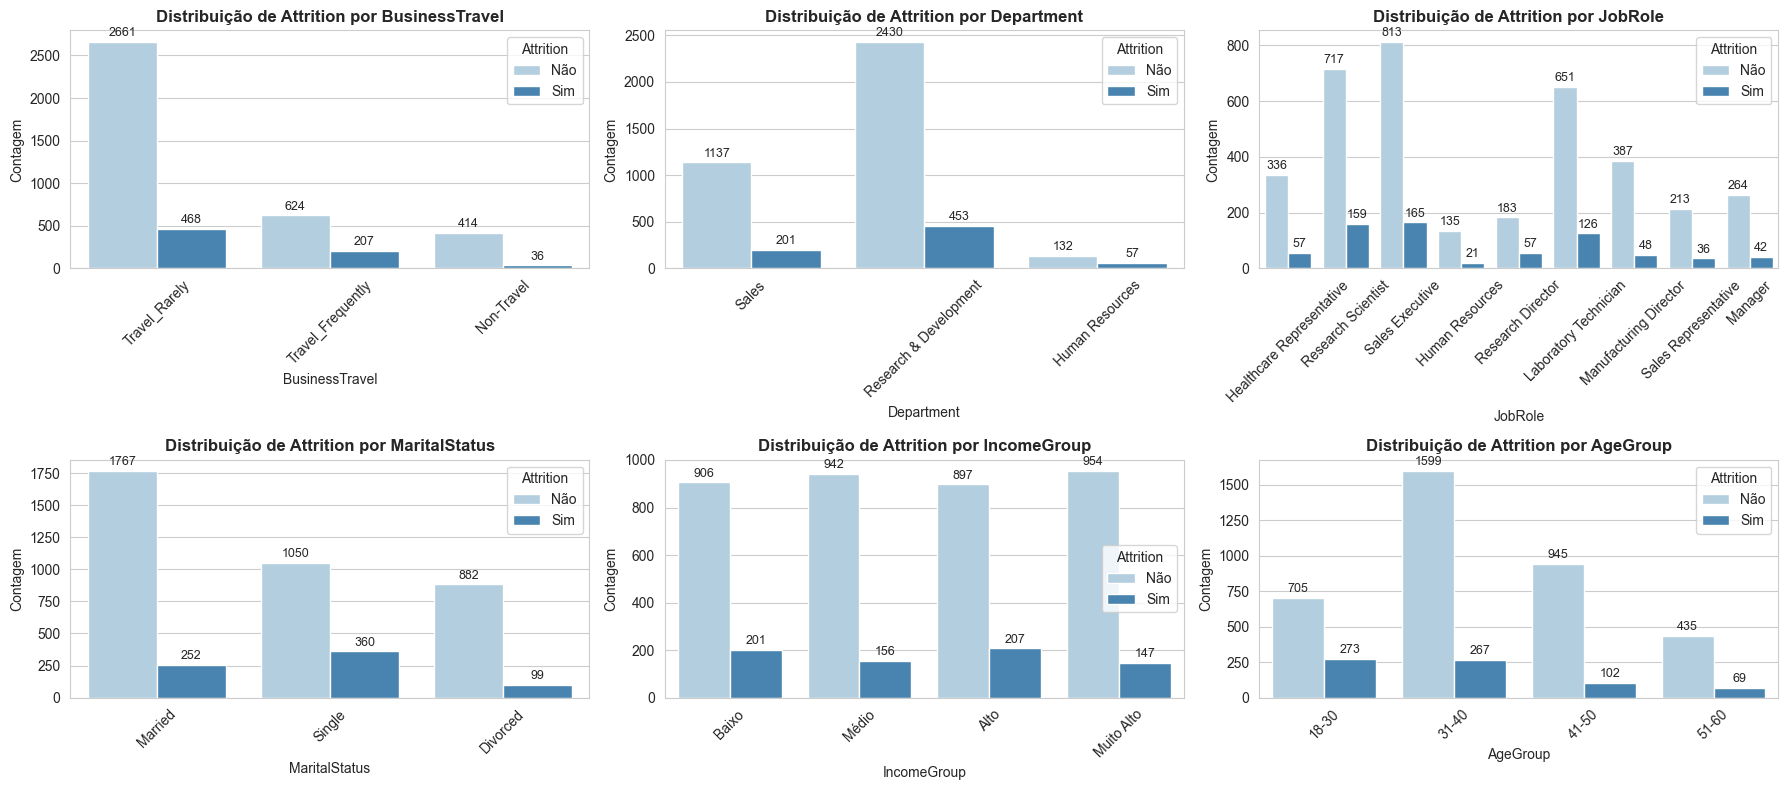

In [193]:
# Lista de variáveis categóricas
categorical_cols = ['BusinessTravel', 'Department',
                    'JobRole', 'MaritalStatus', 
                    'IncomeGroup', 'AgeGroup']

# Define número de colunas e linhas
n_cols = 3
n_rows = math.ceil(len(categorical_cols) / n_cols)

# Cria a figura
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

# Loop pelas variáveis categóricas
for i, col in enumerate(categorical_cols):
    ax = sns.countplot(data=df, x=col, hue='Attrition', palette='Blues', ax=axes[i])
    ax.set_title(f"Distribuição de Attrition por {col}", fontsize=12, fontweight="bold")
    ax.set_xlabel(col)
    ax.set_ylabel("Contagem")
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Attrition', labels=['Não', 'Sim'])
    
    # Adiciona rótulos percentuais
    total = len(df)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=9, padding=2)
    
# Remove eixos extras
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

C:\Users\Notebook\AppData\Local\Temp\ipykernel_10764\1949981752.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop = df.groupby(col)['Attrition'].mean().sort_values(ascending=False) * 100
C:\Users\Notebook\AppData\Local\Temp\ipykernel_10764\1949981752.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop = df.groupby(col)['Attrition'].mean().sort_values(ascending=False) * 100


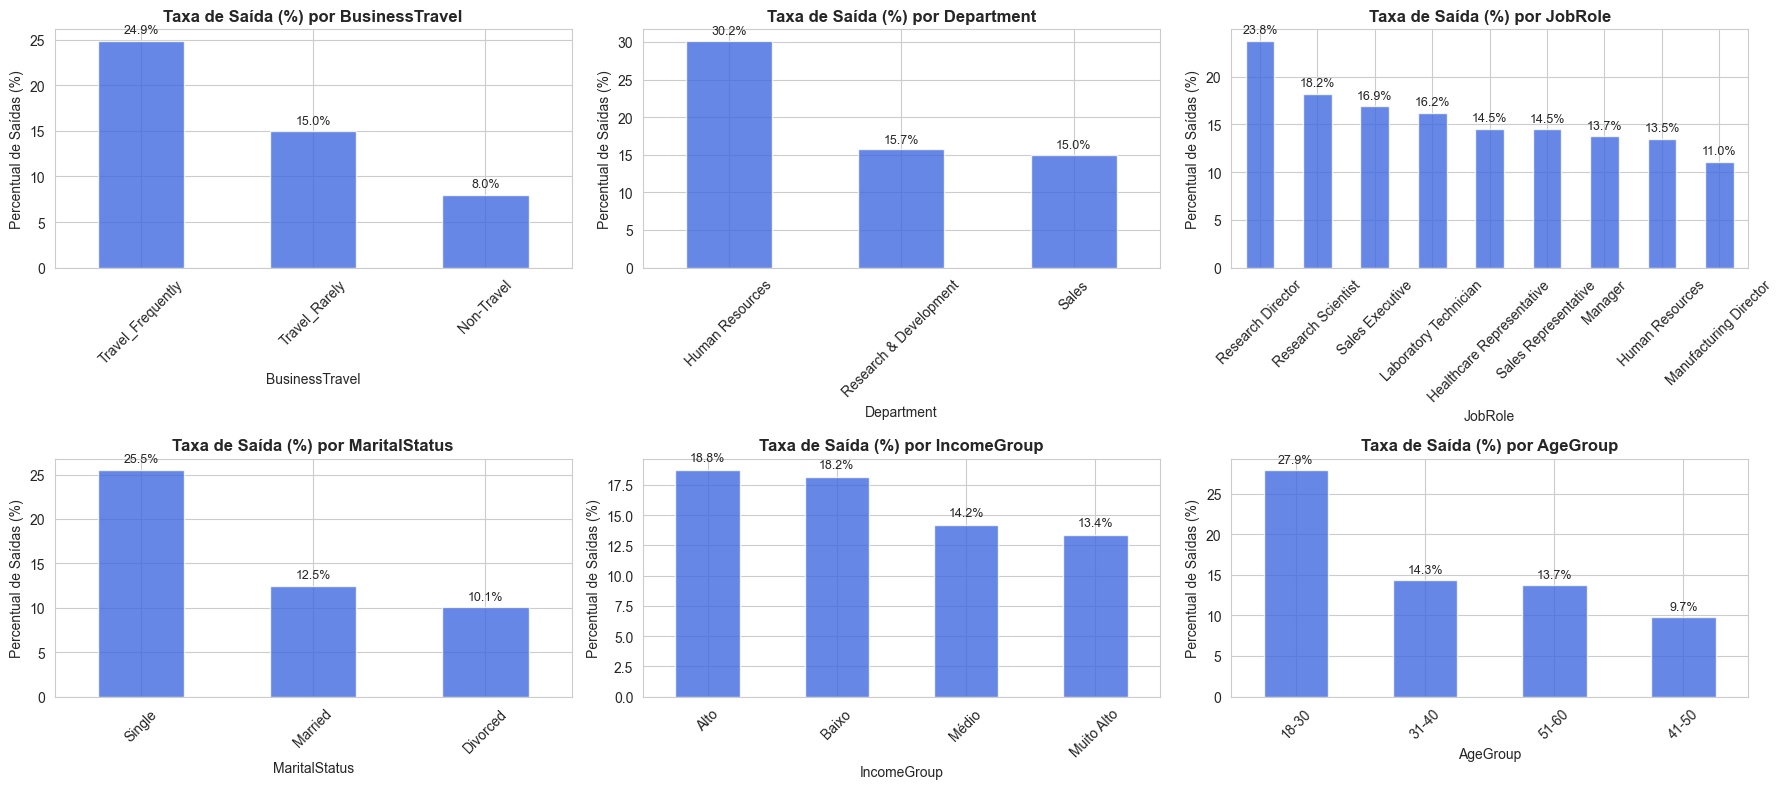

In [194]:
# Variáveis categóricas que queremos analisar
categorical_cols = ['BusinessTravel', 'Department',
                    'JobRole', 'MaritalStatus', 
                    'IncomeGroup', 'AgeGroup']

# Número de colunas e linhas para o layout
n_cols = 3
n_rows = math.ceil(len(categorical_cols) / n_cols)

# Cria a figura
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

# Loop pelas variáveis categóricas
for i, col in enumerate(categorical_cols):
    # Calcula percentual de saídas para cada categoria e ordena
    prop = df.groupby(col)['Attrition'].mean().sort_values(ascending=False) * 100

    # Plota o gráfico de barras
    ax = prop.plot(kind='bar', ax=axes[i], color='royalblue', alpha=0.8)
    ax.set_title(f"Taxa de Saída (%) por {col}", fontsize=12, fontweight="bold")
    ax.set_xlabel(col)
    ax.set_ylabel("Percentual de Saídas (%)")
    ax.tick_params(axis='x', rotation=45)

    # Adiciona rótulos de percentual em cima das barras
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.5,
                f'{p.get_height():.1f}%', ha='center', va='bottom', fontsize=9)

# Remove eixos extras, se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Avaliação: quando verificado a taxa de saída por derpartamento, por exemplo, pode ser observado que Human Resources tem um pulo, tendo em vista a proporção de saídas comparada a quantidade de funcionários.

### 5.2. Aplicar medidas de tendência central

In [195]:
# Selecionar apenas colunas numéricas relevantes para análise de tendência central
numeric_cols = [
    'Age', 'DistanceFromHome', 'Education', 'MonthlyIncome', 'NumCompaniesWorked',
    'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
    'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
    'StockOptionLevel', 'JobLevel', 'AvgYearsPerCompany',
    'PromotionRate', 'FarFromHome', 'MultiCompanyExp', 'CompanyExperienceRatio', 'LongTimeNoPromotion'
]

In [196]:
central_tendency_dic = {}

for col in numeric_cols:
    if col in df.columns:
        mean = df[col].mean()
        median = df[col].median()
        mode = df[col].mode()
        mode_val = mode.iloc[0] if not mode.empty else None
        std_dev = df[col].std()
        central_tendency_dic[col] = {
            'Mean': mean,
            'Median': median,
            'Mode': mode_val,
            'Standard Deviation': std_dev
        }

df_central_tendency_dic = pd.DataFrame(central_tendency_dic).T
df_central_tendency_dic

,Mean,Median,Mode,Standard Deviation
Age,36.923810,36.000000,35.0,9.133301
DistanceFromHome,9.192517,7.000000,2.0,8.105026
Education,2.912925,3.000000,3.0,1.023933
MonthlyIncome,65029.312925,49190.000000,23420.0,47068.888559
NumCompaniesWorked,2.820408,2.000000,1.0,2.372910
PercentSalaryHike,15.209524,14.000000,11.0,3.659108
TotalWorkingYears,11.275737,10.000000,10.0,7.780539
TrainingTimesLastYear,2.799320,3.000000,2.0,1.288978
YearsAtCompany,7.008163,5.000000,5.0,6.125135
YearsSinceLastPromotion,2.187755,1.000000,0.0,3.221699


###### Insight referente ao perfil do colaborador: a empresa tem um perfil de colaboradores adultos, com boa experiência geral, mas ainda em fase intermediária de carreira dentro da empresa.

###### Insight referente a aspectos salariais e de carreira: a disparidade de renda e o baixo acesso a benefícios variáveis (como ações) podem se associar a maior chance de saída (Attrition), especialmente entre níveis baixos.

###### Insight referente a experiência e mobilidade: há um equilíbrio entre estabilidade e mobilidade, mas deslocamentos longos podem ser um fator de risco para Attrition.

###### Insight referente a crescimento e promoção: o crescimento interno é lento e possivelmente concentrado em poucos colaboradores, fator típico de turnover voluntário.

###### Insight de indicadores derivados (relacionais): o comprometimento médio com a empresa é relativamente alto, mas fatores como falta de promoção e desigualdade salarial podem enfraquecê-lo.

#### Boxplot

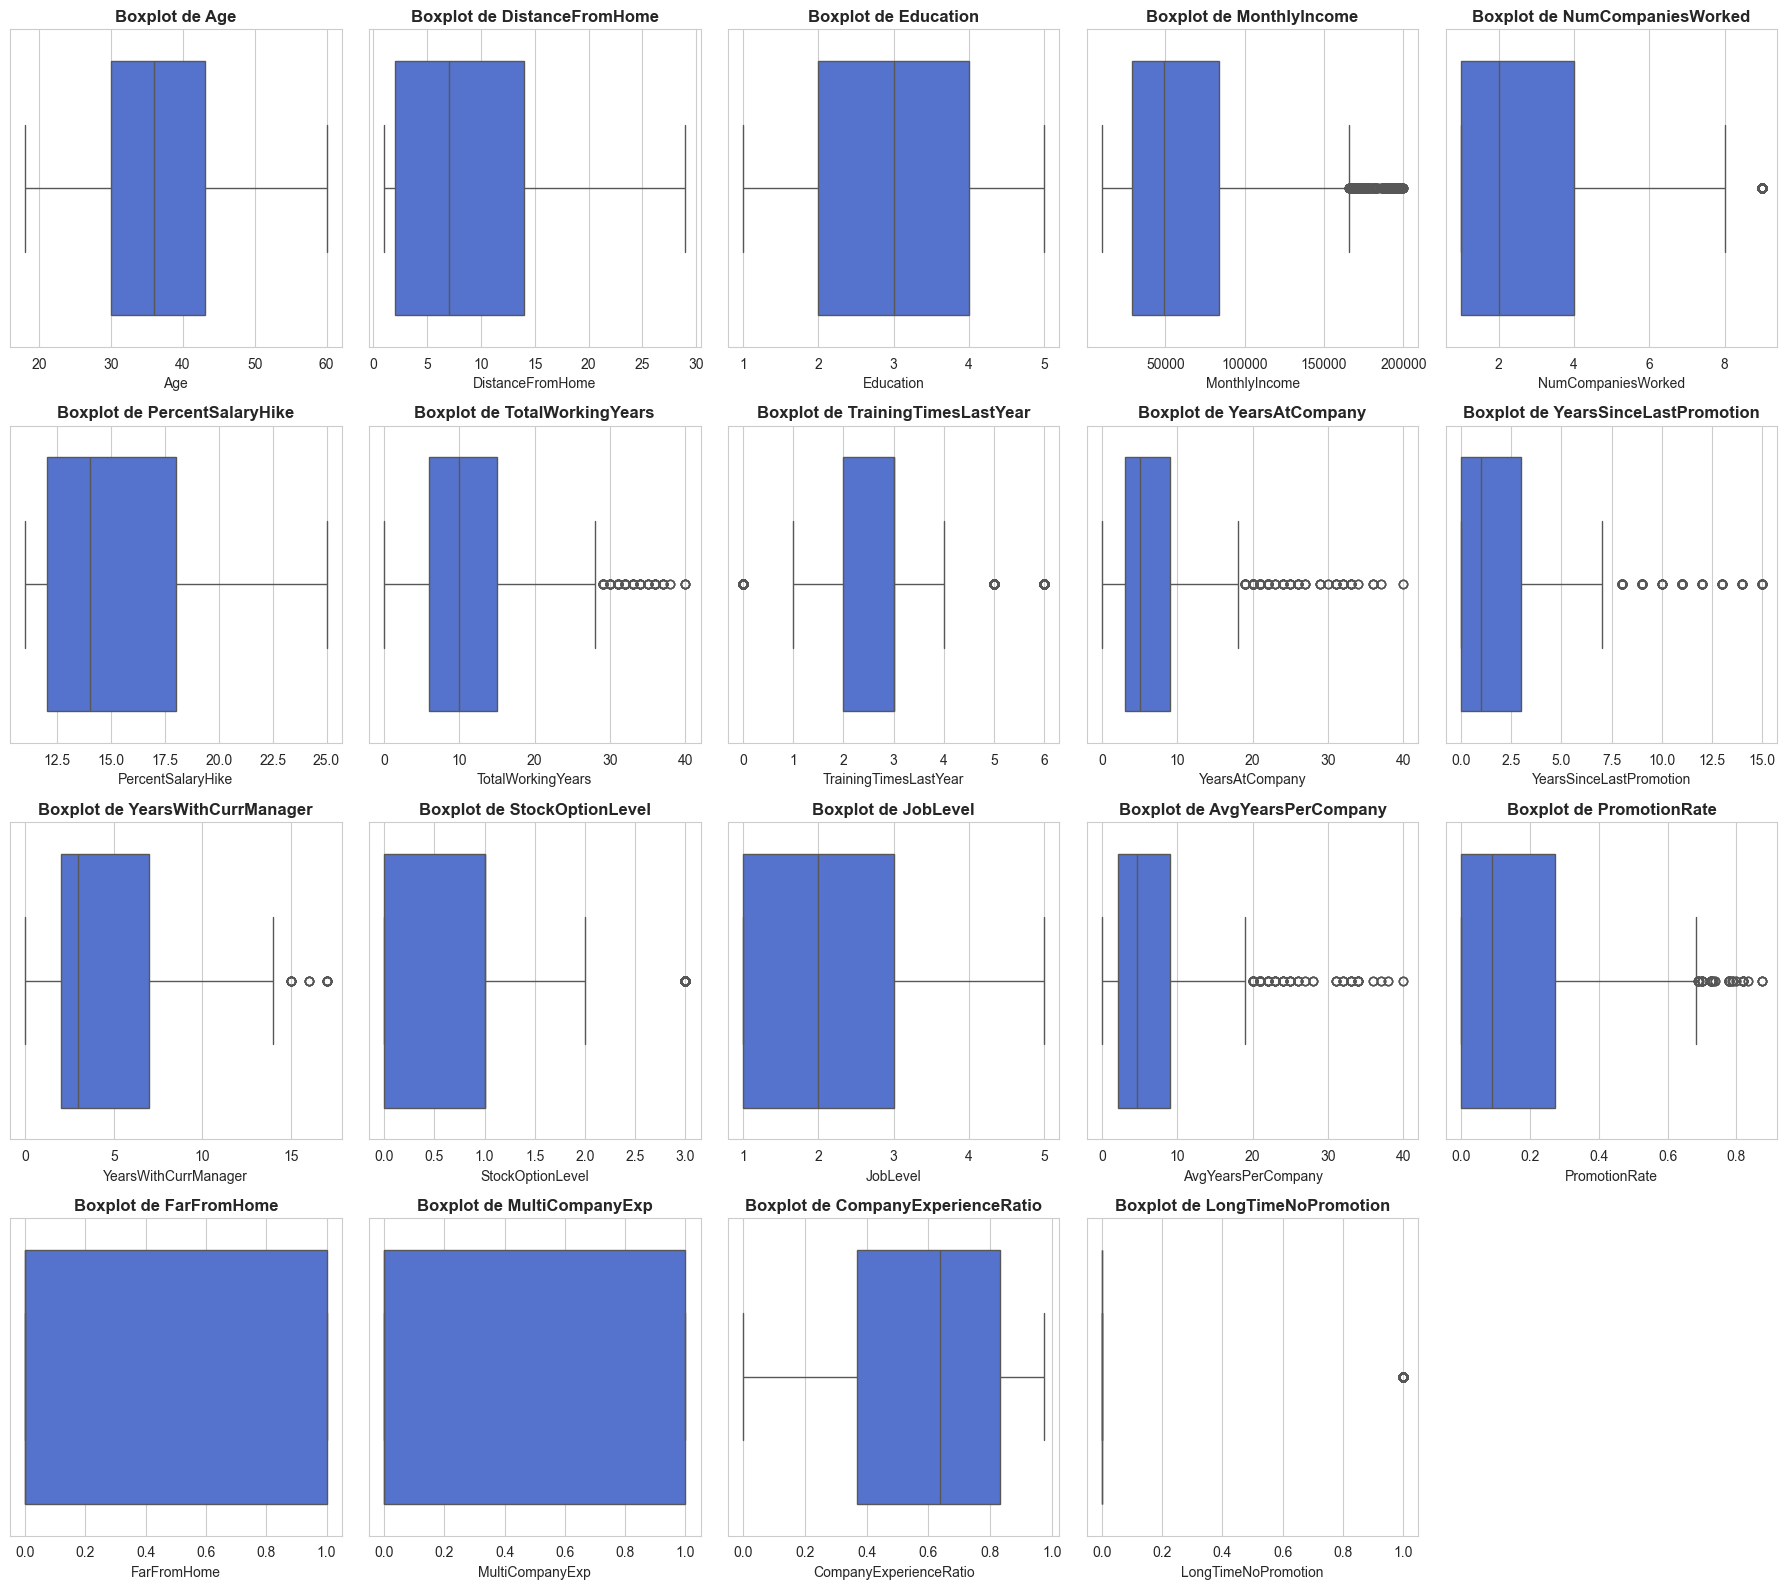

In [197]:
n_cols = 5
n_rows = math.ceil(len(numeric_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    if col in df.columns:
        sns.boxplot(x=df[col], color="royalblue", ax=axes[i])
        axes[i].set_title(f"Boxplot de {col}", fontsize=12, fontweight="bold")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("")

# Remove eixos extras
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##### Conclusões gerais: 

* As variáveis de tempo e carreira (YearsAtCompany, TotalWorkingYears, PromotionRate) mostram padrões diferentes e outliers relevantes, merecem destaque na modelagem.
* MonthlyIncome e JobLevel provavelmente se correlacionam fortemente (devem ser analisadas juntas para evitar multicolinearidade).
* Variáveis binárias como FarFromHome e LongTimeNoPromotion podem ser bons preditores de Attrition, apesar de simples.
* Nenhuma variável precisa ser excluída por enquanto, mas você pode considerar normalizar ou padronizar aquelas com escala muito diferente (como renda e anos de experiência).

#### Histogramas

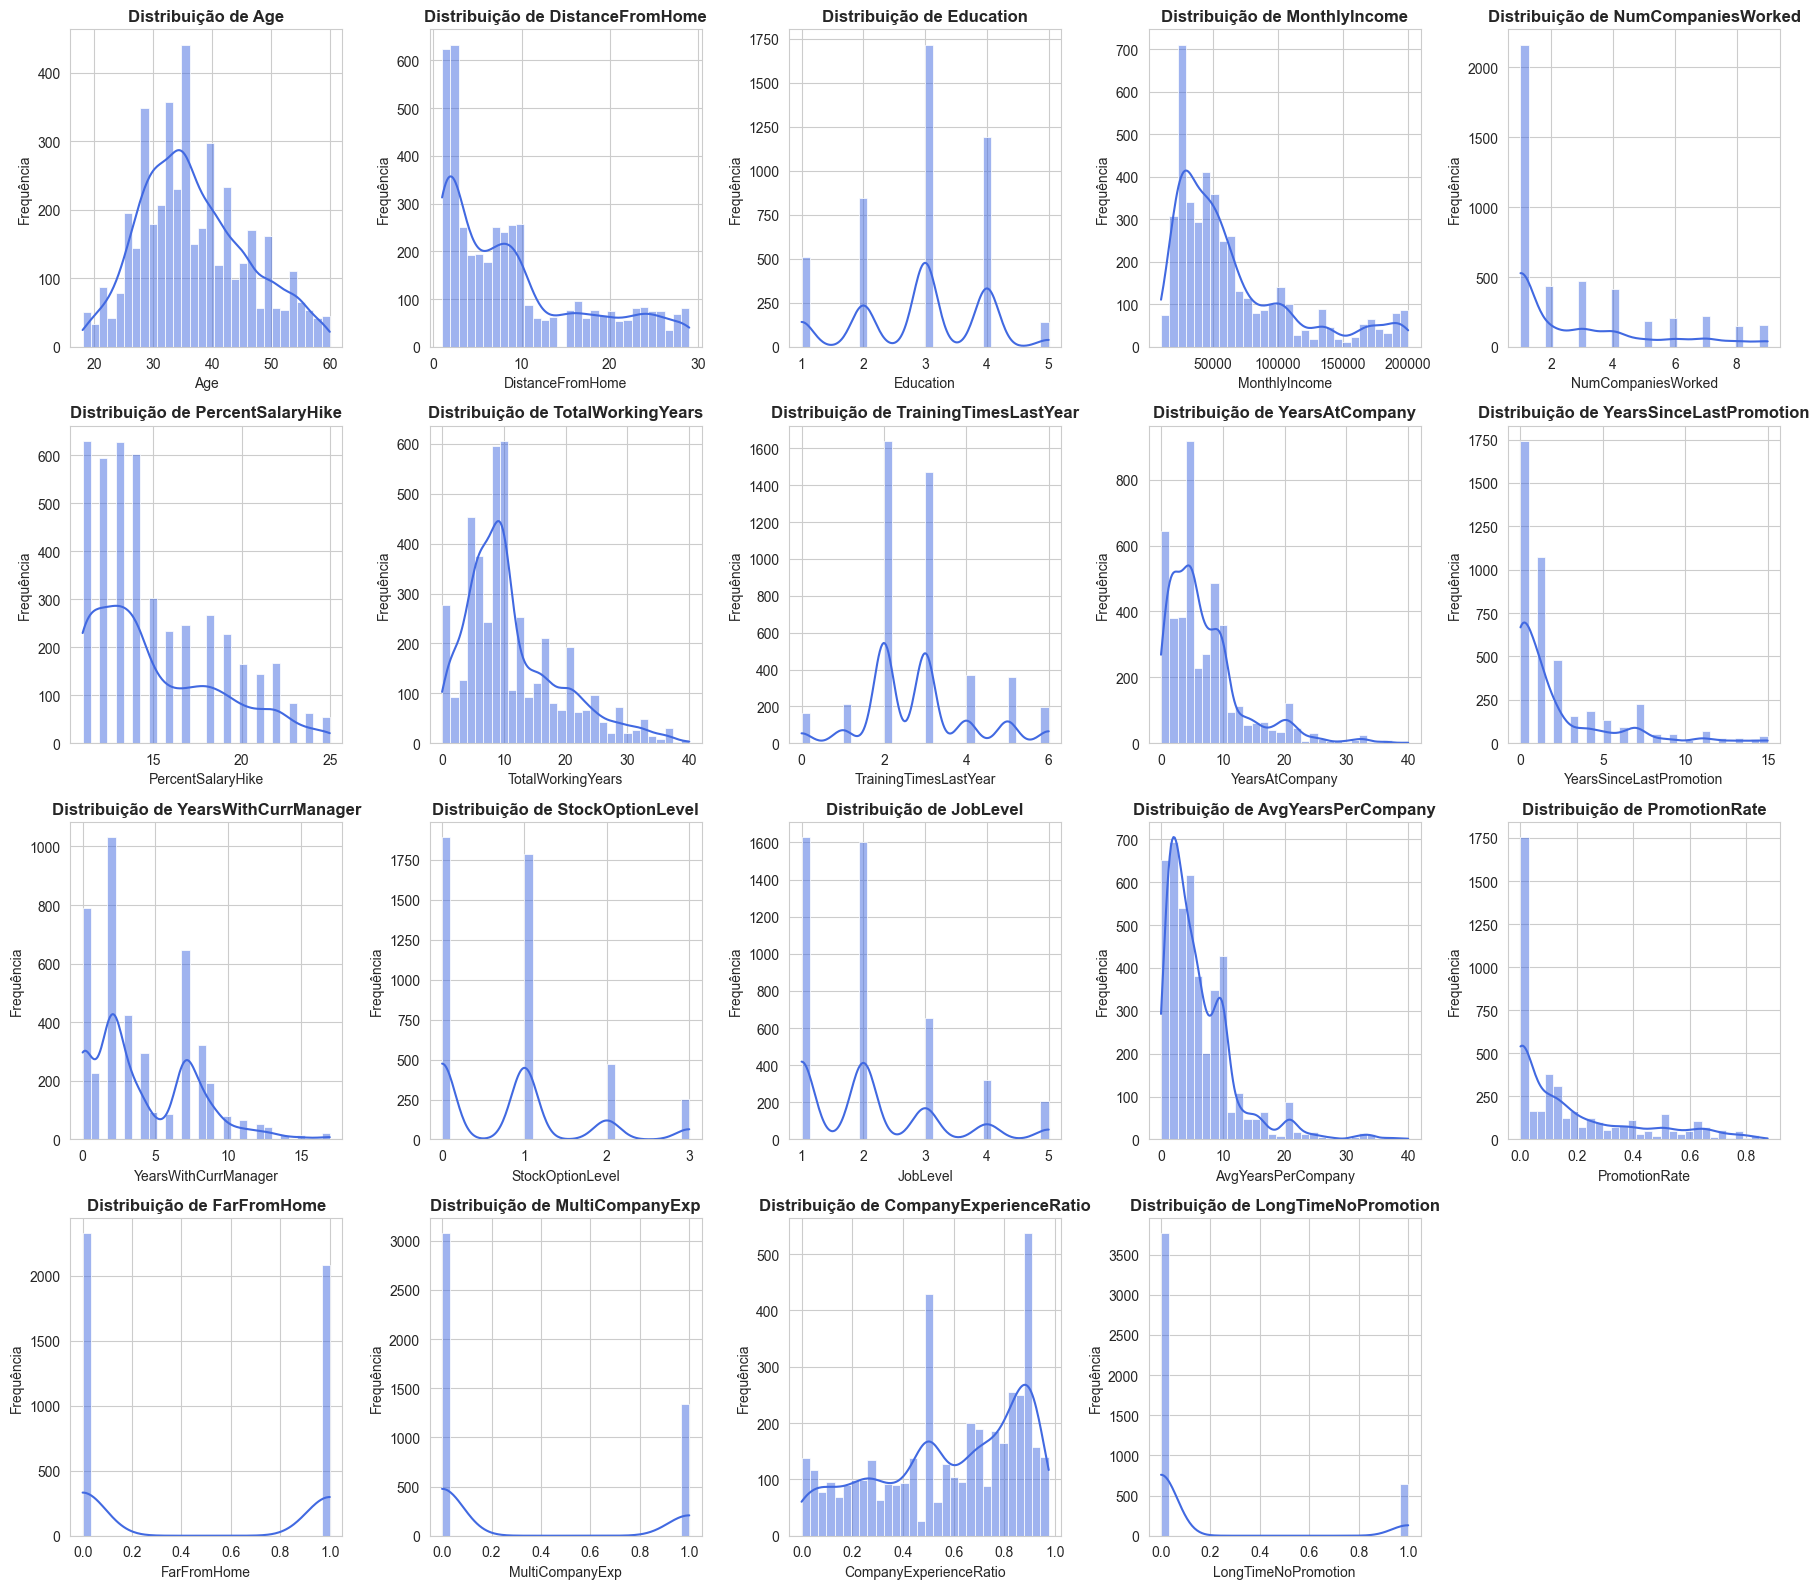

In [198]:
n_cols = 5
n_rows = math.ceil(len(numeric_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    if col in df.columns:
        sns.histplot(df[col], bins=30, kde=True, color="royalblue", ax=axes[i])
        axes[i].set_title(f"Distribuição de {col}", fontsize=12, fontweight="bold")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequência")

# Remove eixos extras
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 5.3. Aplicar matriz de correlação

In [199]:
# Calcule a matriz de correlação de Pearson
correlation_matrix = df[numeric_cols].corr(method='pearson')

print("--- Matriz de Correlação de Pearson ---")
# O .round(2) é para exibir os valores com duas casas decimais, o que melhora a leitura
display(correlation_matrix.round(2))

--- Matriz de Correlação de Pearson ---


,Age,DistanceFromHome,Education,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,StockOptionLevel,JobLevel,AvgYearsPerCompany,PromotionRate,FarFromHome,MultiCompanyExp,CompanyExperienceRatio,LongTimeNoPromotion
Age,1.00,0.01,-0.04,-0.04,0.30,-0.03,0.68,-0.03,0.31,0.22,0.20,-0.03,-0.00,0.26,-0.04,-0.01,0.25,-0.21,0.16
DistanceFromHome,0.01,1.00,-0.01,-0.02,-0.01,0.04,0.01,-0.01,0.03,0.00,0.02,0.01,-0.04,0.05,0.02,0.79,-0.01,0.04,-0.01
Education,-0.04,-0.01,1.00,0.01,-0.02,-0.04,-0.01,0.01,0.01,0.02,0.01,0.00,0.05,0.02,0.01,-0.02,-0.02,-0.01,0.02
MonthlyIncome,-0.04,-0.02,0.01,1.00,-0.02,0.00,-0.03,0.05,0.00,0.07,0.02,0.03,0.05,-0.03,0.07,0.00,-0.05,0.03,0.05
NumCompaniesWorked,0.30,-0.01,-0.02,-0.02,1.00,0.04,0.24,-0.04,-0.11,-0.04,-0.10,0.01,-0.00,-0.45,-0.15,-0.02,0.88,-0.45,-0.04
PercentSalaryHike,-0.03,0.04,-0.04,0.00,0.04,1.00,-0.02,-0.04,-0.03,-0.03,-0.04,0.01,0.01,-0.04,-0.01,0.03,0.02,-0.02,-0.01
TotalWorkingYears,0.68,0.01,-0.01,-0.03,0.24,-0.02,1.00,-0.04,0.63,0.40,0.46,0.00,-0.04,0.56,0.02,-0.00,0.19,-0.06,0.29
TrainingTimesLastYear,-0.03,-0.01,0.01,0.05,-0.04,-0.04,-0.04,1.00,-0.01,0.02,-0.01,-0.07,-0.03,0.01,0.00,0.00,-0.05,0.02,0.03
YearsAtCompany,0.31,0.03,0.01,0.00,-0.11,-0.03,0.63,-0.01,1.00,0.62,0.77,0.01,-0.06,0.78,0.29,0.01,-0.10,0.64,0.46
YearsSinceLastPromotion,0.22,0.00,0.02,0.07,-0.04,-0.03,0.40,0.02,0.62,1.00,0.51,0.02,-0.06,0.43,0.79,-0.01,-0.03,0.38,0.86


#### 5.3.1. Aplicar mapa de calor - Correlação de Person

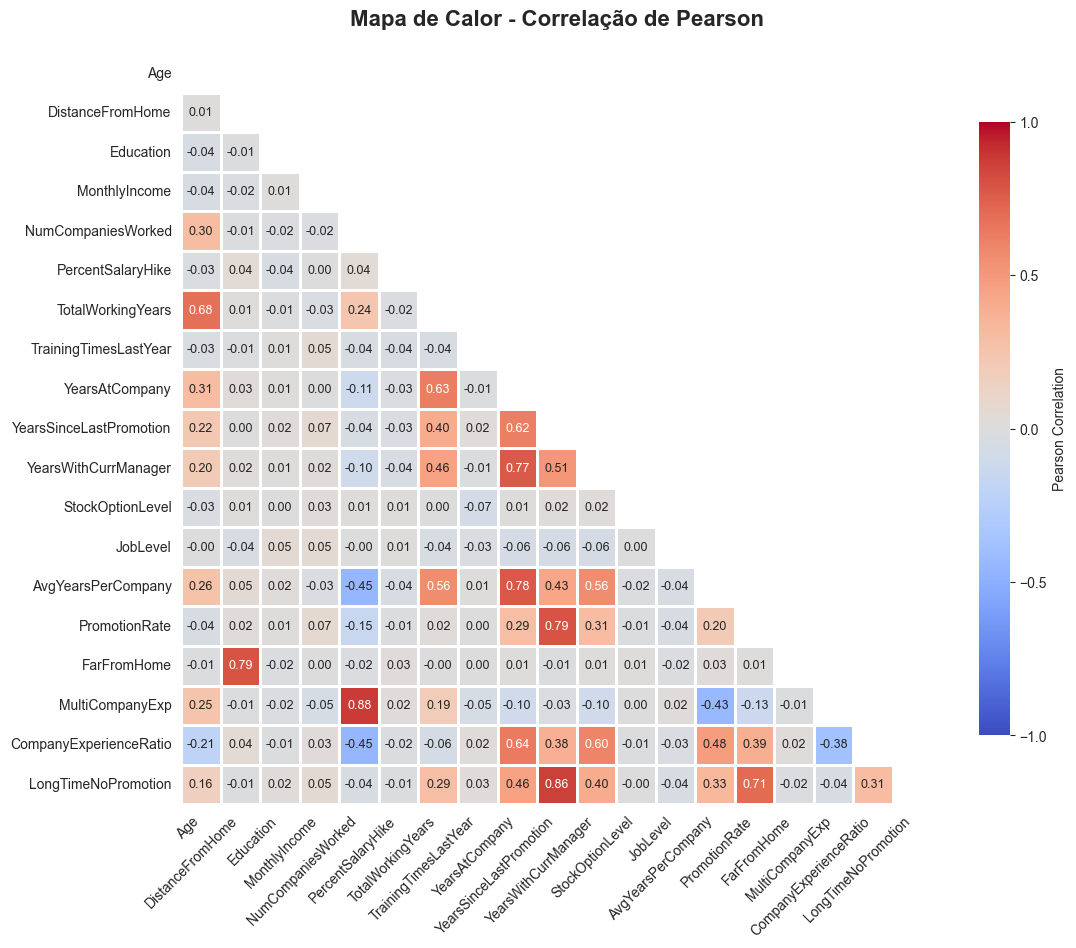

In [200]:
# Heatmap
plt.figure(figsize=(len(numeric_cols) * 0.6, len(numeric_cols) * 0.5))
mask_low_corr = (np.abs(correlation_matrix) < 0.1) & (correlation_matrix != 1.0)

sns.heatmap(
    correlation_matrix.round(2),
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.8,
    square=True,
    center=0,
    vmin=-1, vmax=1,
    cbar_kws={
        "shrink": 0.8,
        "label": "Pearson Correlation",
        "ticks": [-1, -0.5, 0, 0.5, 1]
        },
        annot_kws={
        "fontsize": 9
    }
)

plt.title("Mapa de Calor - Correlação de Pearson", fontsize=16, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()

## 6. Aplicar técnica da análise

### 6.1. Utilizar aprendizado de máquina (supervisionado) - Modelagem e Avaliação Aprimorada

In [205]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'), # class_weight para Random Forest é uma alternativa ao SMOTE
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    print(f"\n--- Treinando {name} ---")
    
    # Para modelos de árvore (RF, XGB), podemos usar os dados escalados ou não, mas o SMOTE é aplicado ao conjunto escalado para consistência
    if name == "Random Forest":
        # Usando class_weight='balanced' como alternativa ao SMOTE para RF
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # Usando dados SMOTE para LogReg e XGBoost
        model.fit(X_train_smote, y_train_smote)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        
    # Avaliação
    report = classification_report(y_test, y_pred, target_names=['No Attrition', 'Attrition (Yes)'], output_dict=True)
    auc = roc_auc_score(y_test, y_proba)
    
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall (Yes)': report['Attrition (Yes)']['recall'],
        'F1-Score (Yes)': report['Attrition (Yes)']['f1-score'],
        'AUC': auc,
        'Report': classification_report(y_test, y_pred, target_names=['No Attrition', 'Attrition (Yes)'])
    }
    
    print(results[name]['Report'])
    print(f"AUC: {auc:.4f}")


--- Treinando Logistic Regression ---
                 precision    recall  f1-score   support

   No Attrition       0.91      0.73      0.81       740
Attrition (Yes)       0.31      0.63      0.41       142

       accuracy                           0.71       882
      macro avg       0.61      0.68      0.61       882
   weighted avg       0.81      0.71      0.75       882

AUC: 0.7442

--- Treinando Random Forest ---
                 precision    recall  f1-score   support

   No Attrition       0.99      1.00      0.99       740
Attrition (Yes)       1.00      0.94      0.97       142

       accuracy                           0.99       882
      macro avg       0.99      0.97      0.98       882
   weighted avg       0.99      0.99      0.99       882

AUC: 0.9988

--- Treinando XGBoost ---


c:\Users\Notebook\Documents\Git\laboratoria-ml-attrition\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:28:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                 precision    recall  f1-score   support

   No Attrition       1.00      1.00      1.00       740
Attrition (Yes)       1.00      0.98      0.99       142

       accuracy                           1.00       882
      macro avg       1.00      0.99      0.99       882
   weighted avg       1.00      1.00      1.00       882

AUC: 0.9999


### 6.2. Comparação de Métricas (Foco em Recall e AUC)

In [206]:
metrics_df = pd.DataFrame({
    'Modelo': results.keys(),
    'Acurácia': [r['Accuracy'] for r in results.values()],
    'Recall (Yes)': [r['Recall (Yes)'] for r in results.values()],
    'F1-Score (Yes)': [r['F1-Score (Yes)'] for r in results.values()],
    'AUC': [r['AUC'] for r in results.values()]
})

metrics_df.sort_values(by='AUC', ascending=False)

,Modelo,Acurácia,Recall (Yes),F1-Score (Yes),AUC
2,XGBoost,0.996599,0.978873,0.989324,0.999867
1,Random Forest,0.990930,0.943662,0.971014,0.998810
0,Logistic Regression,0.713152,0.626761,0.412993,0.744214


## 7. Insights de Negócio: Importância de Variáveis

C:\Users\Notebook\AppData\Local\Temp\ipykernel_10764\915758663.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_15_features.values, y=top_15_features.index, palette='viridis')


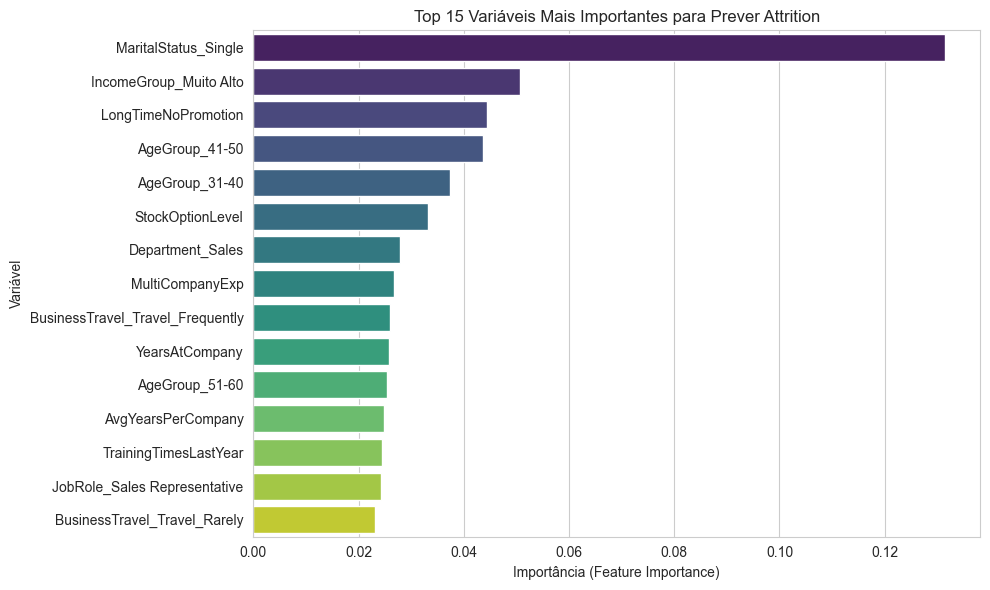

In [209]:
# Escolhendo o melhor modelo 
best_model = models['XGBoost']

# Extraindo a importância das features
feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
top_15_features = feature_importances.nlargest(15)

# Visualização
plt.figure(figsize=(10, 6))
sns.barplot(x=top_15_features.values, y=top_15_features.index, palette='viridis')
plt.title('Top 15 Variáveis Mais Importantes para Prever Attrition')
plt.xlabel('Importância (Feature Importance)')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()